In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from langchain_groq import ChatGroq

llm = ChatGroq(model = "llama3-8b-8192")

## Utilities

In [89]:
def stream_graph_updates(user_input: str, config = None):
    input_state = {
        "messages": [
            {"role": "user", "content": user_input}
        ]
    }

    
    for event in graph.stream(input_state, config = config):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)
        

def initialize_chat(config):
    while True:

        user_input = input("User: ")

        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        
        print("-"* 200)
        print("User : ", user_input)
        stream_graph_updates(user_input, config)
    

## Basic Chatbot

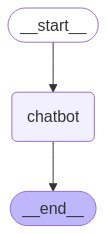

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
User :  what in langgraph ?
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Assistant: I think you meant to ask "What is LangGraph?"

LangGraph is a fascinating topic! LangGraph is a type of linguistic graph that represents the structure of a natural language, typically using nodes and edges to model the relationships between words, phrases, and grammatical dependencies. This graph-based approach enables the analysis and processing of linguistic data in a more efficient and accurate manner.

In LangGraph, each node typically represents a word or a phrase, and the edges between nodes denote the relationships between them, such as:

* Synta

In [23]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict
from typing import Annotated
from langgraph.graph.message import add_messages
from IPython.display import Image, display

class State(TypedDict):
    messages : Annotated[list, add_messages]


def chatbot(state : State):
    """Chatbot """
    return {"messages": [llm.invoke(state['messages'])]}


workflow = StateGraph(State)
workflow.add_node("chatbot", chatbot)
workflow.add_edge(START, "chatbot")
workflow.add_edge("chatbot", END)
graph = workflow.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

## Initialize chat
initialize_chat()


## Chatbot with Tools

In [24]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

[{'title': 'LangGraph Glossary - GitHub Pages',
  'url': 'https://langchain-ai.github.io/langgraph/concepts/low_level/',
  'content': 'In LangGraph, nodes are typically python functions (sync or async) where the first positional argument is the state, and (optionally), the second positional argument is a "config", containing optional configurable parameters (such as a thread_id).\n\nSimilar to NetworkX, you add these nodes to a graph using the add_node method:\n\nAPI Reference: RunnableConfig | StateGraph [...] LangGraph Glossary¶\n\nGraphs¶\n\nAt its core, LangGraph models agent workflows as graphs. You define the behavior of your agents using three key components:\n\nState: A shared data structure that represents the current snapshot of your application. It can be any Python type, but is typically a TypedDict or Pydantic BaseModel.\n\nNodes: Python functions that encode the logic of your agents. They receive the current State as input, perform some computation or side-effect, and ret

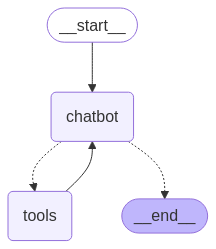

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
User :  what is langchain ?
Assistant: Langchain is a type of language model that is specifically designed to generate human-like text responses to user input. It's a type of artificial intelligence (AI) that uses machine learning algorithms to analyze and generate text based on the input it receives.

Langchain models are trained on large datasets of text and are designed to understand the context and nuances of language. They can be used for a variety of tasks, such as:

* Chatbots: Langchain models can be used to power chatbots that can have natural-sounding conversations with users.
* Content generation: Langchain models can be used to generate content such as articles, blog posts, and social media updates.
* Language translation: Langchain models can be used to translate text from on

In [77]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict
from typing import Annotated
from langgraph.graph.message import add_messages
from IPython.display import Image, display
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt.tool_node import ToolNode

tool = TavilySearchResults(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)

class State(TypedDict):
    messages : Annotated[list, add_messages]


def chatbot(state : State):
    """Chatbot """
    return {"messages": [llm_with_tools.invoke(state['messages'])]}

def route_tools(state : State):
    """Route Tools"""
    
    last_message = state['messages'][-1]
    
    if "tool_calls" in last_message and len(last_message.tool_calls)>0:
        return "tool_node"
    
    return END

tool_node = ToolNode(tools=tools)
workflow = StateGraph(State)

workflow.add_node("chatbot", chatbot)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "chatbot")
workflow.add_conditional_edges("chatbot", route_tools, {"tools": "tools", END : END})
workflow.add_edge("tools", "chatbot")
graph = workflow.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

## Initialize chat
initialize_chat()

## Memory to the Chatbot

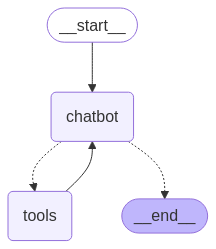

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
User :  my name is saurabh
Assistant: {"tool_calls": [{"id": "pending", "type": "function", "function": {"name": "tavily_search_results_json"}, "parameters": {"query": "saurabh"}}]}
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
User :  what is my name ?
Assistant: My name is Saurabh.
Goodbye!


In [80]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict
from typing import Annotated
from langgraph.graph.message import add_messages
from IPython.display import Image, display
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt.tool_node import ToolNode
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

tool = TavilySearchResults(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)

class State(TypedDict):
    messages : Annotated[list, add_messages]


def chatbot(state : State):
    """Chatbot """
    return {"messages": [llm_with_tools.invoke(state['messages'])]}

def route_tools(state : State):
    """Route Tools"""
    
    last_message = state['messages'][-1]
    
    if "tool_calls" in last_message and len(last_message.tool_calls)>0:
        return "tool_node"
    
    return END

tool_node = ToolNode(tools=tools)
workflow = StateGraph(State)

workflow.add_node("chatbot", chatbot)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "chatbot")
workflow.add_conditional_edges("chatbot", route_tools, {"tools": "tools", END : END})
workflow.add_edge("tools", "chatbot")
graph = workflow.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

## Initialize chat
config = {"configurable": {"thread_id": "1"}}
initialize_chat(config)

## Human-in-the-loop

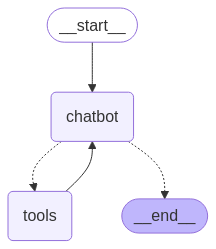

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
User :  my name is saurabh
================================ Human Message =================================

my name is saurabh
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_h52a)
 Call ID: call_h52a
  Args:
    query: saurabh
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Saurabh Sanghvi | McKinsey & Company", "url": "https://www.mckinsey.com/our-people/saurabh-sanghvi", "content": "Saurabh is a partner in McKinsey's Bay Area office and a leader for the firm's education and economic development work. Saurabh works with public, private,", "score": 0.7625837}, {"title": "Saurabh - Wikipedia", "url": "https://en.wikipedia.org/wiki/

In [ ]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict
from typing import Annotated
from langgraph.graph.message import add_messages
from IPython.display import Image, display
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt.tool_node import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.tools import tool
from langgraph.types import Command, interrupt

## memory
memory = MemorySaver()


@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]


tool = TavilySearchResults(max_results=2)
tools = [tool, human_assistance]
llm_with_tools = llm.bind_tools(tools)

class State(TypedDict):
    messages : Annotated[list, add_messages]



def chatbot(state : State):
    """Chatbot """
    message = llm_with_tools.invoke(state['messages'])
    assert len(message.tool_calls) <=1
    return {"messages": [message]}


tool_node = ToolNode(tools=tools)
workflow = StateGraph(State)

workflow.add_node("chatbot", chatbot)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "chatbot")
workflow.add_conditional_edges("chatbot", tools_condition)
workflow.add_edge("tools", "chatbot")
graph = workflow.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

## Initialize chat
config = {"configurable": {"thread_id": "1"}}

def stream_graph_updates(user_input: str, config = None):
    input_state = {
        "messages": [
            {"role": "user", "content": user_input}
        ]
    }

    
    for event in graph.stream(input_state, config = config, stream_mode="values"):
        if "messages" in event:
            event['messages'][-1].pretty_print()

initialize_chat(config)

## Customizing States

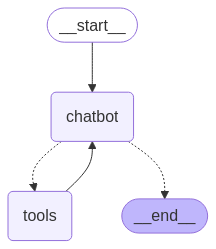

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
User :  Can you look up when LangGraph was released?
================================ Human Message =================================

Can you look up when LangGraph was released?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_ft2p)
 Call ID: call_ft2p
  Args:
    query: LangGraph release date
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Announcing LangGraph v0.1 & LangGraph Cloud: Running agents ...", "url": "https://blog.langchain.dev/langgraph-cloud/", "content": "We also have a new stable release of LangGraph. By LangChain 6 min read Jun 27, 2024. (Oct '24) Edit: Since the launch of LangGraph Cloud, we", "score": 0.83932644}

In [94]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict
from typing import Annotated
from langgraph.graph.message import add_messages
from IPython.display import Image, display
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt.tool_node import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.tools import tool, InjectedToolCallId
from langgraph.types import Command, interrupt
from langchain_core.messages import ToolMessage

## memory
memory = MemorySaver()


def human_assistance(
    name: str, birthday: str, tool_call_id: Annotated[str, InjectedToolCallId]
) -> str:
    """Request assistance from a human."""
    human_response = interrupt(
        {
            "question": "Is this correct?",
            "name": name,
            "birthday": birthday,
        },
    )
    # If the information is correct, update the state as-is.
    if human_response.get("correct", "").lower().startswith("y"):
        verified_name = name
        verified_birthday = birthday
        response = "Correct"
    # Otherwise, receive information from the human reviewer.
    else:
        verified_name = human_response.get("name", name)
        verified_birthday = human_response.get("birthday", birthday)
        response = f"Made a correction: {human_response}"

    # This time we explicitly update the state with a ToolMessage inside
    # the tool.
    state_update = {
        "name": verified_name,
        "birthday": verified_birthday,
        "messages": [ToolMessage(response, tool_call_id=tool_call_id)],
    }
    # We return a Command object in the tool to update our state.
    return Command(update=state_update)



tool = TavilySearchResults(max_results=2)
tools = [tool, human_assistance]
llm_with_tools = llm.bind_tools(tools)

class State(TypedDict):
    messages : Annotated[list, add_messages]



def chatbot(state : State):
    """Chatbot """
    message = llm_with_tools.invoke(state['messages'])
    assert len(message.tool_calls) <=1
    return {"messages": [message]}


tool_node = ToolNode(tools=tools)
workflow = StateGraph(State)

workflow.add_node("chatbot", chatbot)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "chatbot")
workflow.add_conditional_edges("chatbot", tools_condition)
workflow.add_edge("tools", "chatbot")
graph = workflow.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

## Initialize chat
config = {"configurable": {"thread_id": "1"}}

def stream_graph_updates(user_input: str, config = None):
    input_state = {
        "messages": [
            {"role": "user", "content": user_input}
        ]
    }
    for event in graph.stream(input_state, config = config, stream_mode="values"):
        if "messages" in event:
            event['messages'][-1].pretty_print()

initialize_chat(config)